In [ ]:
from IPython.display import clear_output

!pip install pyprind

clear_output()

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import matplotlib.pyplot as plt


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gzip

import os
import glob
import time
import random
import gc
import json
import copy
import pyprind
import tqdm
from dataclasses import dataclass, field
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision
import torchtext

from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [ ]:
!gdown --id 1oYnD7Izl3LVVzjEMyLxLklX30TKWHgGG
!unzip /content/cifar-10.zip
!rm -rf /content/cifar-10.zip
!mv /content/cifar-10/sample_submission.csv /content/cifar-10/test_labels.csv

clear_output()

In [ ]:
def process():
    data = pd.read_csv(os.path.join('/content/cifar-10', 'train_labels.csv'))
    encoder = preprocessing.LabelEncoder()
    encoder.fit(data['label'])
    return encoder

encoder = process()

In [ ]:
data = pd.read_csv(os.path.join('/content/cifar-10', 'train_labels.csv'))
files = data['id']
labels = encoder.transform(data['label'])

train_data_files, valid_data_files, train_data_label, valid_data_label = train_test_split(files, labels, test_size=0.1, shuffle=True, stratify=labels)

train_data = pd.DataFrame({'id': train_data_files, 'label': train_data_label})
valid_data = pd.DataFrame({'id': valid_data_files, 'label': valid_data_label})

unique, counts = np.unique(labels, return_counts=True)
weights = torch.Tensor(sklearn.utils.class_weight.compute_class_weight(class_weight="balanced", classes=unique, y=np.asarray(labels)))

In [ ]:
data = pd.read_csv(os.path.join('/content/cifar-10', 'test_labels.csv'))
test_data_files = data['id']
test_data_label = encoder.transform(data['label'])

test_data = pd.DataFrame({'id': test_data_files, 'label': test_data_label})

In [ ]:
@dataclass
class TrainingArgs():

    seed: int = 17
    lr: float = 3e-4
    batch_size: int = 64
    num_workers: int = os.cpu_count()
    max_epochs: str = 250
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_size: int = 32

    root_dir: str = '/content/cifar-10'
    train_file: dict = train_data
    valid_file: dict = valid_data
    test_file: dict = test_data
    data: tuple = ()
    checkpoint: str = '/content/'

    project_name: str = 'CIFAR10'

args = TrainingArgs()

In [ ]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, args, mode='train'):
        self.args = args
        self.mode = mode

        if mode=='train':
            self.entry = self.args.train_file
        elif mode=='valid':
            self.entry = self.args.valid_file
            self.mode = 'train'
        elif mode=='test':
            self.entry = self.args.test_file    

        self.transform = torchvision.transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ]
        )

    def __getitem__(self, index):
        data = self.entry.iloc[index]
        file_name = os.path.join(self.args.root_dir, self.mode, str(data['id'])+'.png')
        image = Image.open(file_name)
        image = self.transform(image)
        label = data['label']
        return image, label

    def __len__(self):
        return len(self.entry)

---

In [ ]:
train_dataset = CreateDataset(args, mode='train')
valid_dataset = CreateDataset(args, mode='valid')
test_dataset = CreateDataset(args, mode='test')

args.data = (train_dataset, valid_dataset, test_dataset)

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

---

In [ ]:
data = next(iter(trainloader))

In [ ]:
data[0].shape, data[1].shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

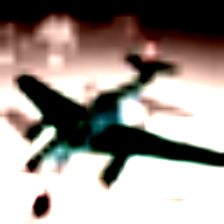

airplane


In [ ]:
index = 0

image = cv2.resize(data[0][index].permute(1, 2, 0).numpy()*255, (224, 224))
label = encoder.inverse_transform(data[1])[index]

cv2_imshow(image)
print(label)

In [ ]:
#Resnet34
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

def conv7x7(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # Activation function - max(0,x)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.layer4 = self.make_layer(block, 128, layers[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1) 
        out = self.fc(out)
        return out


model = ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
#Resnet18
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # Activation function - max(0,x)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.layer4 = self.make_layer(block, 128, layers[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1) 
        out = self.fc(out)
        return out


model = ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
class Trainer():
    def __init__(self, args, architecture):

        self.args = args

        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        torch.manual_seed(self.args.seed)
        torch.cuda.manual_seed(self.args.seed)
        torch.cuda.manual_seed_all(self.args.seed)

        self.trainloader, self.validloader, self.testloader = self.get_iterator(self.args.data)
        
        self.model = architecture.to(self.args.device) # self.get_model()
        self.criterion = self.get_criterion()
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()

        self.train_loss = []
        self.train_metrics = {'accuracy': []}
        self.valid_loss = []
        self.valid_metrics = {'accuracy': []}

        self.start_epoch = 0

    def get_iterator(self, data):
        train, valid, test = data
        trainloader = DataLoader(train, batch_size=self.args.batch_size, shuffle=True, num_workers=self.args.num_workers, pin_memory=True, drop_last=True)
        validloader = DataLoader(valid, batch_size=self.args.batch_size, shuffle=False, num_workers=self.args.num_workers, pin_memory=True, drop_last=True)
        testloader = DataLoader(test, batch_size=self.args.batch_size, shuffle=False, num_workers=self.args.num_workers, pin_memory=True, drop_last=False)
        return trainloader, validloader, testloader

    def get_criterion(self):
        return nn.CrossEntropyLoss(weight=weights).to(self.args.device)
    
    def get_optimizer(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.args.lr)

    def get_scheduler(self):
        return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.args.max_epochs, eta_min=1e-12, last_epoch=-1, verbose=False)

    def get_model(self, architecture):
        model = ResNet(args).to(self.args.device)
        return model

    def get_model_params(self):
        return sum(p.numel() for p in self.model.parameters())/1e6

    def get_accuracy(self, output, label):
        return (torch.argmax(output, dim=1)==label).float().sum().item()

    def save(self, epoch):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, os.path.join(self.args.checkpoint, "model.pth"))
        torch.save({
            'epoch': epoch,
            'args': args,
            'loss': (self.train_loss, self.valid_loss),
            'metrics': (self.train_metrics, self.valid_metrics)
            }, os.path.join(self.args.checkpoint, "metrics.pth"))
        
    def load(self):
        if os.path.exists(os.path.join(self.args.checkpoint, "model.pth")):
            checkpoints = torch.load(os.path.join(self.args.checkpoint, "model.pth"), map_location=self.args.device)
            self.model.load_state_dict(checkpoints['model_state_dict'])
            self.optimizer.load_state_dict(checkpoints['optimizer_state_dict'])

        if os.path.exists(os.path.join(self.args.checkpoint, "metrics.pth")):
            checkpoints = torch.load(os.path.join(self.args.checkpoint, "metrics.pth"), map_location=self.args.device)
            self.args = checkpoints['args']
            self.train_loss, self.valid_loss = checkpoints['loss']
            self.train_metrics, self.valid_metrics = checkpoints['metrics']
            return checkpoints['epoch']
        return 0

    def train(self):
        epoch_loss = 0
        epoch_metrics = {'accuracy': 0}

        gc.collect()
        torch.cuda.empty_cache()
        self.model.train()

        with torch.autograd.set_detect_anomaly(True):
            bar = pyprind.ProgBar(len(self.trainloader), bar_char='█')
            for index, (data, label) in enumerate(self.trainloader):
                data = data.to(self.args.device).float()
                label = label.long().to(self.args.device)

                self.optimizer.zero_grad()
                
                output = self.model(data)

                loss = self.criterion(output, label)

                loss.backward()

                self.optimizer.step()

                epoch_loss += loss.item()/len(self.trainloader)

                epoch_metrics['accuracy'] += self.get_accuracy(output, label)/len(self.args.data[0])

                bar.update()
                gc.collect()
                torch.cuda.empty_cache()

        return epoch_loss, epoch_metrics

    def evaluate(self):
        epoch_loss = 0
        epoch_metrics = {'accuracy': 0}

        gc.collect()
        torch.cuda.empty_cache()
        self.model.eval()

        with torch.autograd.set_detect_anomaly(True):
            with torch.no_grad():
                bar = pyprind.ProgBar(len(self.validloader), bar_char='█')
                for index, (data, label) in enumerate(self.validloader):
                    data = data.to(self.args.device).float()
                    label = label.long().to(self.args.device)

                    output = self.model(data)

                    loss = self.criterion(output, label)

                    epoch_loss += loss.item()/len(self.validloader)
                    epoch_metrics['accuracy'] += self.get_accuracy(output, label)/len(self.args.data[1])

                    bar.update()
                    gc.collect()
                    torch.cuda.empty_cache()

        return epoch_loss, epoch_metrics

    def test(self):

        gc.collect()
        torch.cuda.empty_cache()
        self.model.eval()

        outputs = torch.empty([0,])

        with torch.autograd.set_detect_anomaly(True):
            with torch.no_grad():
                bar = pyprind.ProgBar(len(self.testloader), bar_char='█')
                for index, (data, label) in enumerate(self.testloader):
                    data = data.to(self.args.device)

                    output = torch.argmax(self.model(data)).detach().cpu()
                    outputs = torch.cat((outputs, output), dim=0)

                    bar.update()
                    gc.collect()
                    torch.cuda.empty_cache()

        return outputs
    
    def fit(self, next=True):
        if next:
            self.start_epoch = self.load()

        for epoch in range(self.start_epoch+1, self.args.max_epochs+1, 1):

            epoch_train_loss, epoch_train_metrics = self.train()
            epoch_train_accuracy = epoch_train_metrics['accuracy']

            self.train_loss.append(epoch_train_loss)
            self.train_metrics['accuracy'].append(epoch_train_metrics['accuracy'])

            epoch_valid_loss, epoch_valid_metrics = self.evaluate()
            epoch_valid_accuracy = epoch_valid_metrics['accuracy']

            
            self.valid_loss.append(epoch_valid_loss)
            self.valid_metrics['accuracy'].append(epoch_valid_metrics['accuracy']) 

            self.scheduler.step()
            for param_group in self.optimizer.param_groups:
                self.args.lr = param_group['lr']
            if epoch_valid_metrics['accuracy'] >= max(self.valid_metrics['accuracy']):
                self.save(epoch)

            time.sleep(1)
            print(f'Epoch {epoch}/{self.args.max_epochs} | Training: Loss = {round(epoch_train_loss, 4)}  Accuracy = {round(epoch_train_accuracy, 4)} | Validation: Loss = {round(epoch_valid_loss, 4)}  Accuracy = {round(epoch_valid_accuracy, 4)}')

# Training

In [ ]:
trainer = Trainer(args, architecture=model)

In [ ]:
trainer.fit()

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:28
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Epoch 1/250 | Training: Loss = 1.4824  Accuracy = 0.4541 | Validation: Loss = 1.2464  Accuracy = 0.5458


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:15
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Epoch 2/250 | Training: Loss = 1.0399  Accuracy = 0.6282 | Validation: Loss = 0.9934  Accuracy = 0.6514


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Epoch 3/250 | Training: Loss = 0.8124  Accuracy = 0.7158 | Validation: Loss = 0.8548  Accuracy = 0.6968


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:15
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Epoch 4/250 | Training: Loss = 0.6656  Accuracy = 0.7663 | Validation: Loss = 0.8246  Accuracy = 0.721


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:13
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


Epoch 5/250 | Training: Loss = 0.5512  Accuracy = 0.8092 | Validation: Loss = 0.8392  Accuracy = 0.7216


0% [████████████████              ] 100% | ETA: 00:01:03